In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [18]:
original_data = pd.read_csv('save_data.csv')

n_input_dims = 6
original_data_x = np.array(original_data.iloc[:, 0:n_input_dims])
original_data_y = np.array(original_data.iloc[:, 11:15])
n_data_pts = original_data_x.shape[0]
n_output_dims = original_data_y.shape[1]


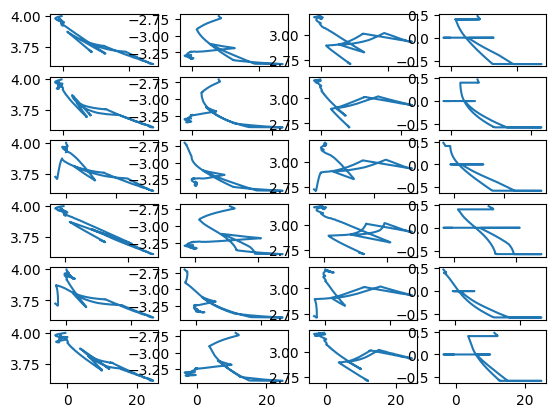

In [19]:
fig, axs = plt.subplots(n_input_dims, n_output_dims)
for r in range(0, n_input_dims):
    for c in range(0, n_output_dims):
        axs[r, c].plot(original_data_x[:, r], original_data_y[:, c], label = 'length left spring')
plt.show()


In [6]:
def sliding_windows(data_x, data_y, seq_length):
    x = []
    y = []

    for i in range(len(data_x)-seq_length-1):
        _x = data_x[i:(i+seq_length), :]
        _y = data_y[i+seq_length, :]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [20]:
training_data_x = np.zeros(original_data_x.shape)
for ind in range(0, n_input_dims):
    min_v = np.min(original_data_x[:, ind])
    max_v = np.max(original_data_x[:, ind])
    training_data_x[:, ind] = (original_data_x[:, ind] - min_v) / (max_v - min_v)

keep_min_max = []
training_data_y = np.zeros(original_data_y.shape)
for ind in range(0, original_data_y.shape[1]):
    min_v = np.min(original_data_y[:, ind])
    max_v = np.max(original_data_y[:, ind])
    training_data_y[:, ind] = (original_data_y[:, ind] - min_v) / (max_v - min_v)
    keep_min_max.append((min_v, max_v))


In [21]:
seq_length = 4
x, y = sliding_windows(training_data_x, training_data_y, seq_length)

train_size = int(n_data_pts * 0.67)
test_size = n_data_pts - train_size

dataX = Variable(torch.Tensor(x))

trainX = Variable(torch.Tensor(x[0:train_size]))

testX = Variable(torch.Tensor(x[train_size:len(x)]))


In [9]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [22]:
num_epochs = 2000
learning_rate = 0.01

input_size = n_input_dims
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = []
for ind in range(0, n_output_dims):
  lstm.append( LSTM(num_classes, input_size, hidden_size, num_layers) )  

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for ind, lstm_ch in enumerate(lstm):
  optimizer = torch.optim.Adam(lstm_ch.parameters(), lr=learning_rate)

  trainY = Variable(torch.Tensor(np.array(y[0:train_size, ind], ndmin=2).T))
  for epoch in range(num_epochs):
      output = lstm_ch(trainX)
      optimizer.zero_grad()
    
      # obtain the loss function
      loss = criterion(output, trainY)
    
      loss.backward()
    
      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.05750
Epoch: 100, loss: 0.00034
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00006
Epoch: 500, loss: 0.00005
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00005
Epoch: 1200, loss: 0.00004
Epoch: 1300, loss: 0.00006
Epoch: 1400, loss: 0.00004
Epoch: 1500, loss: 0.00004
Epoch: 1600, loss: 0.00004
Epoch: 1700, loss: 0.00004
Epoch: 1800, loss: 0.00004
Epoch: 1900, loss: 0.00004
Epoch: 0, loss: 0.54616
Epoch: 100, loss: 0.00855
Epoch: 200, loss: 0.00351
Epoch: 300, loss: 0.00094
Epoch: 400, loss: 0.00041
Epoch: 500, loss: 0.00025
Epoch: 600, loss: 0.00020
Epoch: 700, loss: 0.00018
Epoch: 800, loss: 0.00015
Epoch: 900, loss: 0.00014
Epoch: 1000, loss: 0.00012
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00010
Epoch: 1300, loss: 0.00009
Epoch: 1400, loss: 0.00008
Epoch: 1500, loss: 0.00007
Epoch: 1600, loss: 0.00007
Epoch: 1700, loss: 0.0000

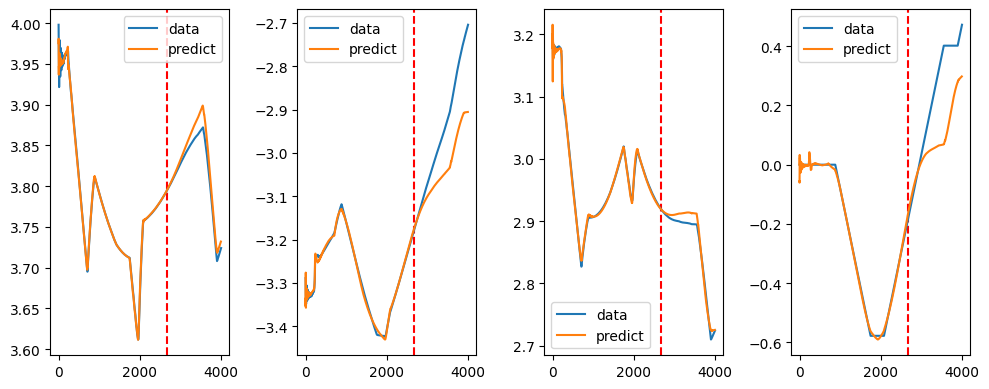

In [23]:
fig, axs = plt.subplots(1, n_output_dims, figsize=(10, 4))

for ind, l in enumerate(lstm):
    axs[ind].axvline(x=train_size, c='r', linestyle='--')
    l.eval()
    train_predict = l(dataX)
    data_predict_prescale = train_predict.data.numpy()

    min_max = keep_min_max[ind]
    data_predict = min_max[0] + data_predict_prescale * (min_max[1] - min_max[0])

    axs[ind].plot(original_data_y[:, ind], label="data")
    axs[ind].plot(data_predict, label="predict")

    axs[ind].legend()

fig.tight_layout()
plt.show()